# Tree Based Methods
Notebook adapted and inspired from: https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb

Tree-based methods are **simple** and **useful for interpretation**. However they typically are not competitive with the best supervised learning approaches in terms of prediction accuracy.

**Bagging**, **Random Forests**, and **boosting** grows multiple trees which are then combined to yield a single consensus prediction. Combining a large number of trees can often result in dramatic improvements in prediction accuracy, at the expense of some loss interpretation.

In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Decision Tree

In [2]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X = iris['data']
y = iris['target']
feature_names = iris['feature_names']

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

We can plot the trained tree using the ``plot_tree``function:

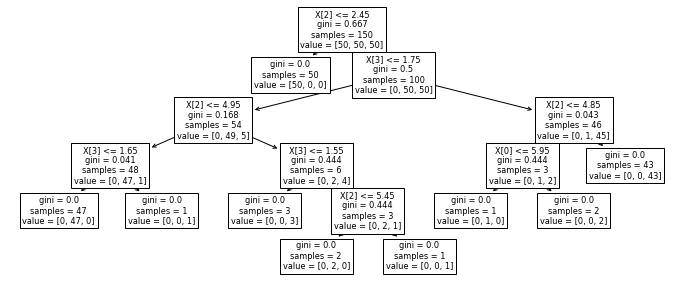

In [3]:
tree.plot_tree(clf)
plt.show()

import graphviz 

In [4]:
# We can
from sklearn.tree import export_text
r = export_text(clf, feature_names=iris['feature_names'])
print(r)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- petal width (cm) <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- petal width (cm) >  1.65
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal length (cm) <= 5.95
|   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  5.95
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



In [5]:
#If the data is two dimensional we can plot the decision boundary
 


In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)
        
        plt.figure(figsize=(8, 4))

Text(4.05, 0.5, '(Depth=2)')

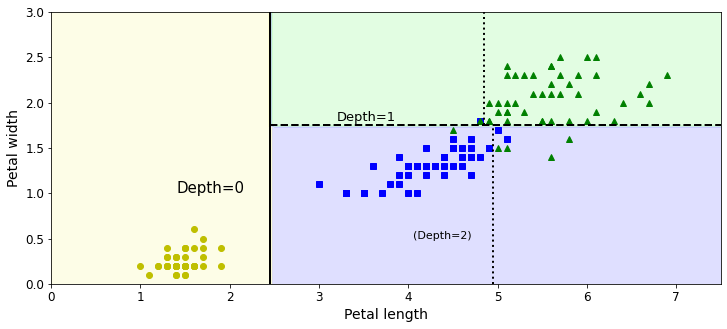

In [7]:
X = iris['data'][:,2:]
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X, y)

plot_decision_boundary(clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)

plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

We can create a deeper tree

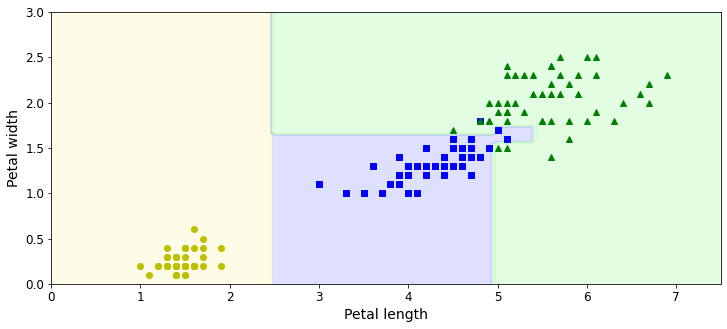

In [8]:
clf = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X, y)
plot_decision_boundary(clf, X, y)

Let's see another example with a more complicate data. Some moons!

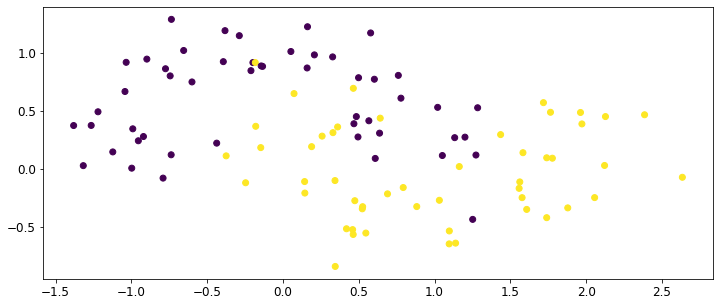

In [9]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

plt.scatter(Xm[:,0],Xm[:,1],c = ym)
plt.show()

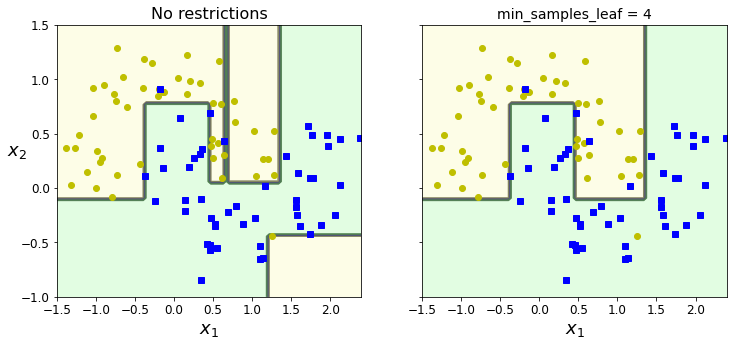

In [10]:
clf1 = tree.DecisionTreeClassifier(random_state=42)
clf2 = tree.DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
clf1.fit(Xm, ym)
clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, sharey=True)
plt.sca(axes[0])
plot_decision_boundary(clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

In the previous example we can see that decission tree is very sensitive to the outliers. Check what happens with tree tree without restricions in the bottom right corner!


Instead of using GINI as split criterion we can use ...

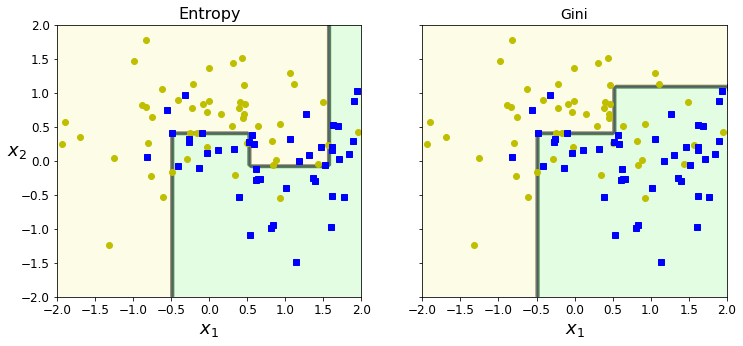

In [11]:
Xm, ym = make_moons(n_samples=100, noise=0.5, random_state=5)


clf1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=42)
clf2 = tree.DecisionTreeClassifier(max_depth=3,random_state=42)
clf1.fit(Xm, ym)
clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, sharey=True)
plt.sca(axes[0])
plot_decision_boundary(clf1, Xm, ym, axes=[-2, 2, -2, 2], iris=False)
plt.title("Entropy", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(clf2, Xm, ym, axes=[-2, 2, -2, 2], iris=False)
plt.title("Gini", fontsize=14)
plt.ylabel("")

plt.show()

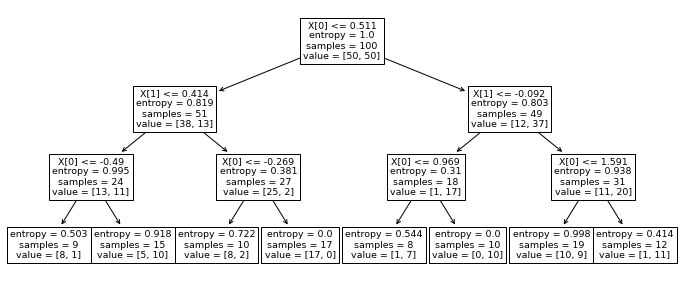

In [13]:
tree.plot_tree(clf1)
plt.show()

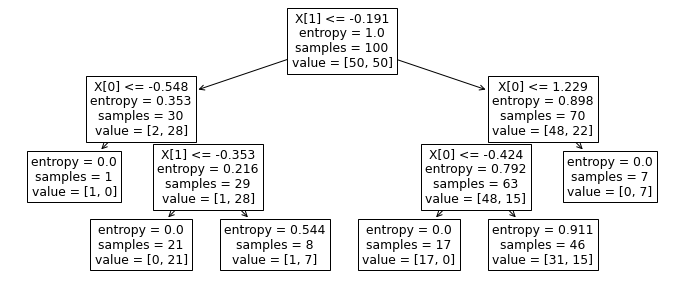

In [14]:
tree.plot_tree(clf2)
plt.show()

## Decision Tree for Regression

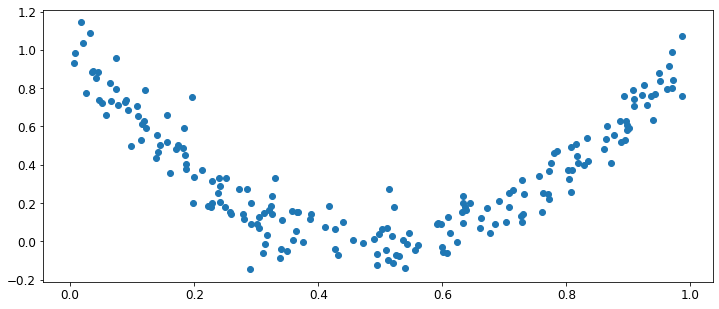

In [15]:

# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

plt.scatter(X, y)

In [16]:
tree_reg = tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

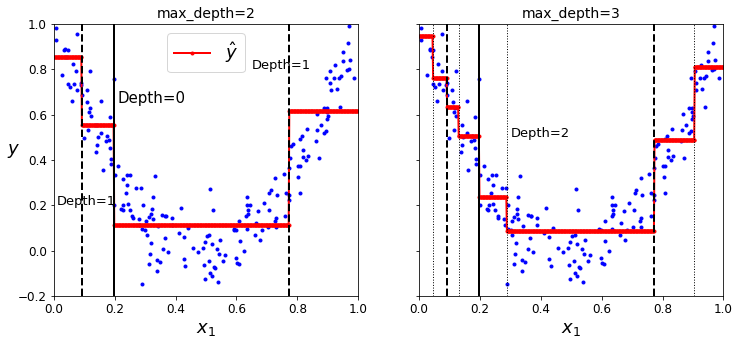

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

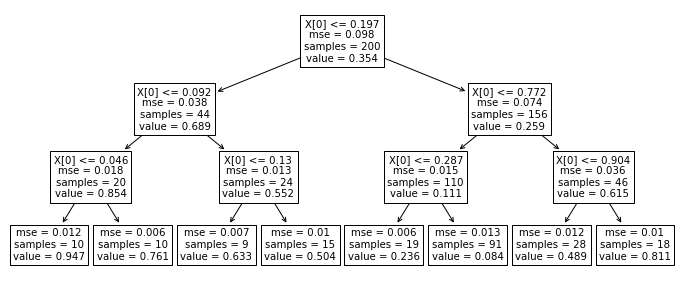

In [18]:
tree.plot_tree(tree_reg2)
plt.show()

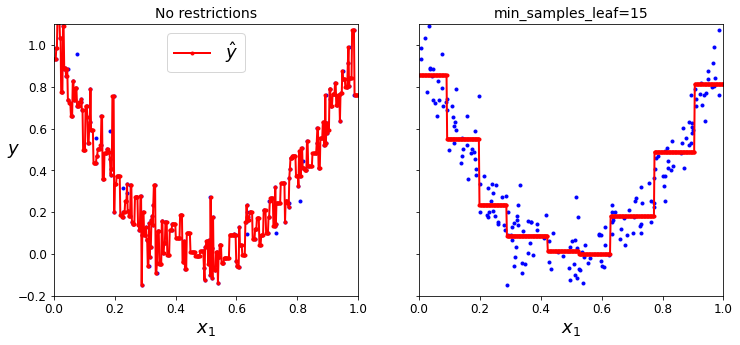

In [19]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=15)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## BAGGING

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



bag_clf = BaggingClassifier(
    tree.DecisionTreeClassifier(random_state=42,max_depth=5), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [22]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [23]:
tree_clf = tree.DecisionTreeClassifier(random_state=42,max_depth=5)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.896


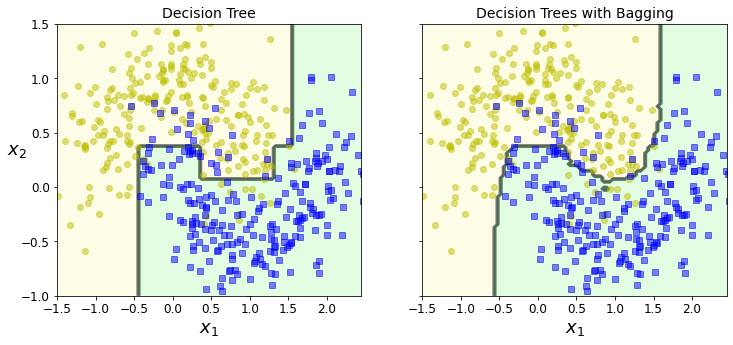

In [24]:
fix, axes = plt.subplots(ncols=2, sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y,axes=[-1.5, 2.45, -1, 1.5],)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y,axes=[-1.5, 2.45, -1, 1.5])
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [26]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions


0.976

In [27]:
rnd_clf.feature_importances_

array([0.41250016, 0.58749984])

In [28]:
rnd_clf.feature_importances_

array([0.41250016, 0.58749984])

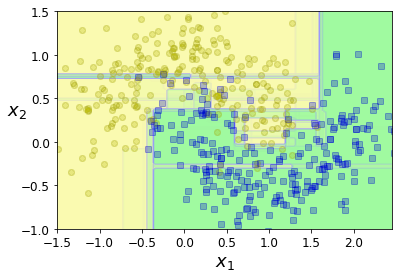

In [29]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = tree.DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()